# Custora Takehome

Run pip install -r /path/to/requirements.txt

The version of the notebook server is 4.2.3 and is running on:
Python 2.7.12 |Anaconda custom (64-bit)| (default, Jun 29 2016, 11:07:13) [MSC v.1500 64 bit (AMD64)]



In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, f1_score, make_scorer
from sklearn.cross_validation  import train_test_split, ShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
import numpy as np
from scipy import stats
#import os
import plotly, plotly.plotly as py, plotly.graph_objs as go

pd.options.mode.chained_assignment = None  #Remove warning that tells me I'm working on a copy of a slice.

%matplotlib inline

### Data ingestion and preprocessing. 

I remove null values and outliers. I would normally scale the data before feeding into my model but because I am going with a random forest classifier as my algorithm of choice, this step is not necessary. This is due to the fact that by nature RFs measure the relationship between the predictor and the response.

In [10]:
df_raw = pd.read_csv('918981743_T_ONTIME_2015_11.csv')

In [11]:
def clean_data(df, threshold, column):
    df_drop_missing = df.dropna(thresh=threshold, axis=1) #Drop the columns that have a significant amount of data missing
    df_drop_missing.dropna(axis=0, inplace=True) #Drop the rows containing null values
    df_outlier = df_drop_missing[(np.abs(
        stats.zscore(df_drop_missing[column])) < 3).all(axis=1)] #Remove outliers from target column for cleaner visualization
    return df_outlier

In [12]:
df_clean = clean_data(df_raw, 300000, ['DEP_DELAY'])

### Q1
Create some basic summary tables or graphs illustrating the distribution of departure delays. Break it down by some other variables in the data set. What variables you pick here is up to you, but see if you can find any patterns.


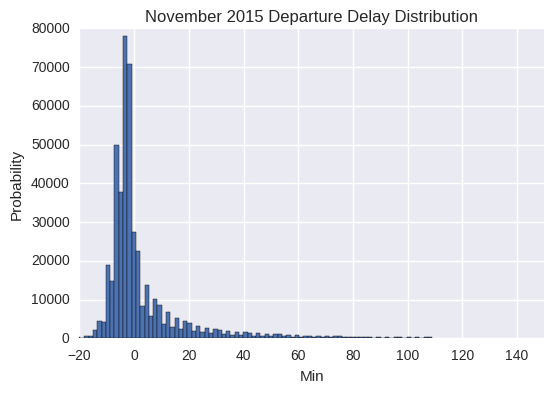

In [14]:
plt.hist(df_clean.DEP_DELAY, bins = 100)
plt.xlabel('Min')
plt.xlim(-20, 150)
plt.ylabel('Probability')
plt.title('November 2015 Departure Delay Distribution')

From visual inspection, the data is positively skewed and this makes sense since most of the delays would tend to be on the shorter side. 

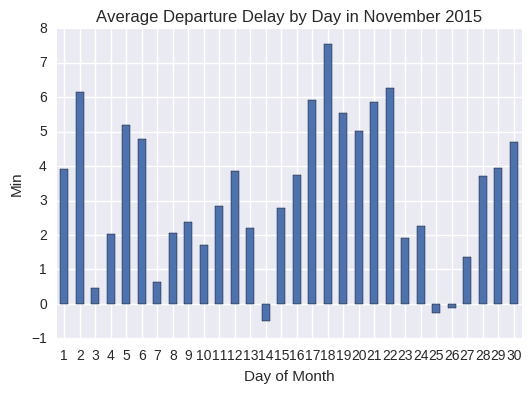

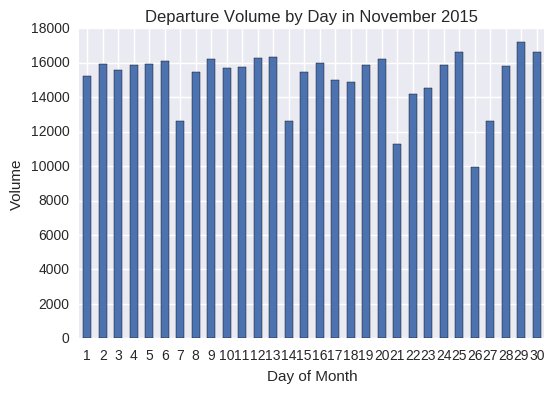

In [15]:
ax = df_clean[['DAY_OF_MONTH','DEP_DELAY']].groupby('DAY_OF_MONTH').mean().plot(kind='bar')
ax.legend_.remove()
plt.xticks(rotation=0)
plt.xlabel('Day of Month')
plt.ylabel('Min')
plt.title('Average Departure Delay by Day in November 2015')

ax = df_clean[['DAY_OF_MONTH','DEP_DELAY']].groupby('DAY_OF_MONTH').count().plot(kind='bar')
ax.legend_.remove()
#df_clean[['DAY_OF_MONTH','DEP_DELAY']].groupby('DAY_OF_MONTH').count().plot(kind='bar')
plt.xticks(rotation=0)
plt.xlabel('Day of Month')
plt.ylabel('Volume')
plt.title('Departure Volume by Day in November 2015')

November 3rd, 7th, 14th, 25 and 26th had the least amount of delay on average. The 25th and 26th make sense since it is during Thanksgiving. I compared the delay to the volume each day to see if I could find anything interesting. After googling the non-holiday dates I found that the decrease in volume on November 7th could be due to the Russian metrojet getting shot down. Also November 14th there was a terror attack in Paris on November 14th which could have led to less travel volume that day. Finally November 21 drop in volume could be due to the fact that Brussels had their terror alert at the highest possible level. Although these events were not in the US they could still have some sort of an effect.

<function matplotlib.pyplot.legend>

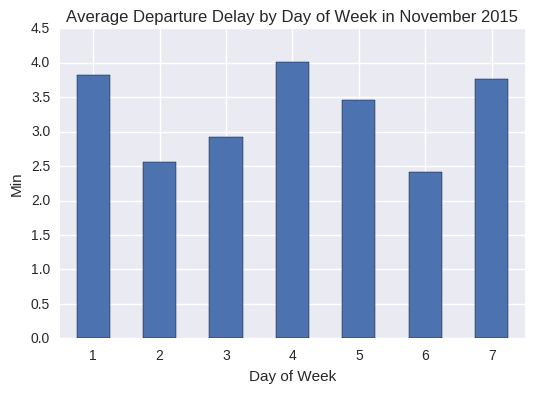

In [16]:
ax = df_clean[['DAY_OF_WEEK','DEP_DELAY']].groupby('DAY_OF_WEEK').mean().plot(kind='bar')
ax.legend_.remove()
plt.xticks(rotation=0)
plt.xlabel('Day of Week')
plt.ylabel('Min')
plt.title('Average Departure Delay by Day of Week in November 2015')
plt.legend

Day 1 is Monday, day 2 is Tuesday, etc. We can see that for the month of November, the worst days to fly were Monday, Thursday, Friday, and Sunday with regards to departure delays.

<function matplotlib.pyplot.legend>

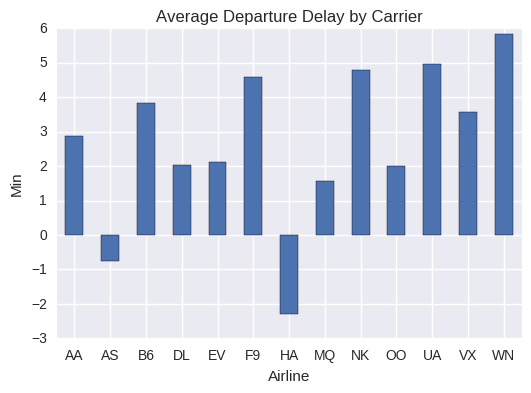

In [17]:
ax = df_clean[['UNIQUE_CARRIER','DEP_DELAY']].groupby('UNIQUE_CARRIER').mean().plot(kind='bar')
ax.legend_.remove()
plt.xticks(rotation=0)
plt.xlabel('Airline')
plt.ylabel('Min')
plt.title('Average Departure Delay by Carrier')
plt.legend

We can see AS and HA airlines are actually early on average while WN, UA, and F9 airlines have the highest departure delay on average.

In [18]:
#create hour column to be able to look at delay across hours of the day
df_clean['DEP_HOUR'] = df_clean['CRS_DEP_TIME']//100

<function matplotlib.pyplot.legend>

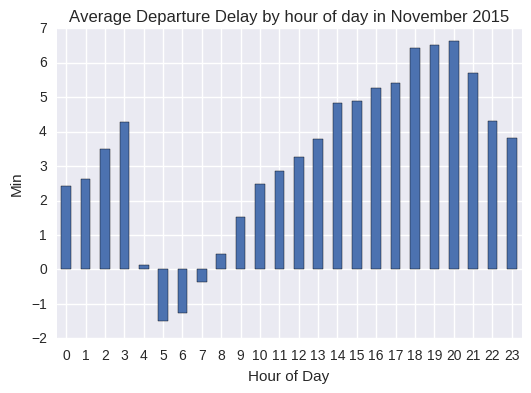

In [19]:
ax = df_clean[['DEP_HOUR','DEP_DELAY']].groupby('DEP_HOUR').mean().plot(kind='bar')
ax.legend_.remove()
plt.xticks(rotation=0)
plt.xlabel('Hour of Day')
plt.ylabel('Min')
plt.title('Average Departure Delay by hour of day in November 2015')
plt.legend

Finally I plot by hour of day and we can see that the least delays occur early in the morning

### Q2
Build a model to predict departure delay, and:
* Explain the predictive technique that you used and why you chose it. What are its assumptions, strengths, and limitations?
* Explain how you chose features from the data set to use in your model. If you generated your own features by transforming those from the data set, explain how you came up with those.
* Discuss the predictive importances of the features that you ended up using. 

In order to predict whether a flight is delayed or not, I made this into a binary classification problem. I chose to count anything greater than 0 as a delay. 

In [20]:
def binarize(df, col, new_col):
    for i, row in df.iterrows():
        if row[col]>0:
            df.set_value(i, new_col, 1)
        else:
            df.set_value(i, new_col, 0)
    return df

In [21]:
binarize(df_clean, 'DEP_DELAY', 'DELAYED')

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,AIRLINE_ID,CARRIER,TAIL_NUM,...,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,DISTANCE,DEP_HOUR,DELAYED
0,2015,4,11,4,3,2015-11-04,AA,19805,AA,N3CHAA,...,25.0,816.0,1333.0,16.0,1352,1349.0,-3.0,1671.0,8,0.0
1,2015,4,11,5,4,2015-11-05,AA,19805,AA,N3LTAA,...,20.0,1756.0,1949.0,3.0,2019,1952.0,-27.0,1739.0,17,0.0
2,2015,4,11,6,5,2015-11-06,AA,19805,AA,N3MKAA,...,12.0,1802.0,2004.0,3.0,2019,2007.0,-12.0,1739.0,17,1.0
3,2015,4,11,7,6,2015-11-07,AA,19805,AA,N3MJAA,...,10.0,1746.0,1945.0,4.0,2019,1949.0,-30.0,1739.0,17,0.0
4,2015,4,11,8,7,2015-11-08,AA,19805,AA,N3MAAA,...,18.0,1758.0,1951.0,5.0,2019,1956.0,-23.0,1739.0,17,0.0
5,2015,4,11,9,1,2015-11-09,AA,19805,AA,N3JVAA,...,22.0,1759.0,1953.0,5.0,2019,1958.0,-21.0,1739.0,17,0.0
6,2015,4,11,10,2,2015-11-10,AA,19805,AA,N3LCAA,...,18.0,1758.0,1951.0,3.0,2019,1954.0,-25.0,1739.0,17,0.0
7,2015,4,11,11,3,2015-11-11,AA,19805,AA,N3LYAA,...,20.0,1812.0,2015.0,4.0,2019,2019.0,0.0,1739.0,17,1.0
8,2015,4,11,12,4,2015-11-12,AA,19805,AA,N3LFAA,...,15.0,1856.0,2110.0,4.0,2019,2114.0,55.0,1739.0,17,1.0
9,2015,4,11,13,5,2015-11-13,AA,19805,AA,N3MDAA,...,14.0,1752.0,2003.0,4.0,2019,2007.0,-12.0,1739.0,17,0.0


Split the data into train and test data so that I can evaluate the performance of my model out of sample. I chose to use the Origin Airport, Departure Hour, Day of the Week, Airline, Destination Airport, Taxi Out time and Distance as my features. Differences in the airport could cause delays due to the efficiency of the layout etc. The hour of the day as seen in the visualization definitely has an impact as flights in the early morning are not going to be delayed on average compared to flights later in the day. The airline also could play a role in delays as well as the taxi out time since it could be related to a departure delay. Finally the distance of the trip could have a role in increasing delay. 

In [22]:
df_features = df_clean[['ORIGIN_AIRPORT_ID', 'DEP_HOUR', 'DAY_OF_WEEK', 'AIRLINE_ID', 'DEST_AIRPORT_ID', 'TAXI_OUT', 'DISTANCE']]
X_train, X_test, y_train, y_test = train_test_split(df_features, df_clean.DELAYED, test_size=0.35)

I chose to use a Random Forest classifier to predict whether or not a flight would be delayed. Random Forests work by creating decision trees based on random subsets of the data as well as a random selection of variables. The value to predict is then run through each of the trees and the class prediction with the most votes is the predicted class of the Random Forest. In order to deal with the fact that there are many more on time flights than flights that I have designated as delayed, I used a balanced weighting scheme built into the random forest classifier in scikit-learn which  increases the f-score of the minority class.

I used gridsearchCV with five fold cross validation and f1 scoring to tune the alorithm and find the best parameters. With more time I would tune the number of estimators as well. This took about five minutes on my computer.

In [23]:
param_grid = {"max_depth": [3, 8], "min_samples_leaf": [1, 10]}
rf = RandomForestClassifier(
    n_estimators=100, random_state=0, class_weight="balanced")
grid_search = GridSearchCV(
    rf, param_grid=param_grid, cv=5, scoring=make_scorer(f1_score)).fit(
        np.array(X_train), np.array(y_train))

print 'best params: ', grid_search.best_params_

best params:  {'max_depth': 8, 'min_samples_leaf': 1}


Random forests produce a feature importance array. These values are calculated with the mean deacrease impurity metric and thus we can see how much each feature contributes to the models predictive performance.

<Container object of 7 artists>

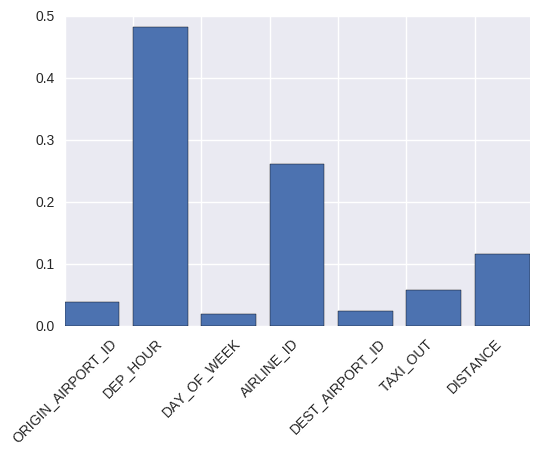

In [24]:
X = range(len(grid_search.best_estimator_.feature_importances_))
y = grid_search.best_estimator_.feature_importances_

plt.xticks(X, X_train.columns, rotation = 45)
plt.bar(X, y)

The hour of the day that the flight departed, the airline itself and the distance of the flight are the three most predictive features. Intuitively this makes sense. After visual inspection for example, the hour of day seemed to exhibit large differences when compared to something like the day of the week. Furthermore, certain airlines are definitely worse than others when it comes to service meaning maybe operating procedures of each airline or routes that certain airlines fly cause some to be more delayed than others. My idea that airports might have an impact doesn't seem to hold true.

### Q3
Validate how well the model does on out-of-sample data. Describe any patterns you see in the quality of your predictions. 


In [25]:
y_pred = grid_search.predict(X_test)

In [26]:
print classification_report(y_test, y_pred)

             precision    recall  f1-score   support

        0.0       0.77      0.64      0.70    108563
        1.0       0.43      0.59      0.50     50254

avg / total       0.66      0.62      0.64    158817



In [28]:
print accuracy_score(y_test, y_pred)

0.624498636796


The accuracy score of 0.62 is much better than randomly guessing a delay which would be yield an accuracy score ~33%. The f1 score is 0.64 but individually the f1 score (harmonic mean of precision and recall) for the minority class would be much worse than for the majority class if I hadn't used balanced weighting. 

### Q4
What are some concerns that would come up if we were to use this predictor to predict departure delays in December 2015? In November 2016? In November 2006 or 2026? 



There are events that occur in December unique to that month when compared to November. One example of this is flight trends around holidays. People usually have the 25th and 26th of November off but often times in December people get weeks or more off. Our model would fail to capture that trend and thus would be inaccurate. Predicting delays far into the future or the past means that the model will be less predictive if over years, there is a general shift in delay patterns (maybe a change in flying patterns from generation to generation or new laws that didn't exist before). 

### Q5
I wanted to get latitude and longitude data and use it to plot each airport on a map and have the delay correspond to the size of the bubble.

In [29]:
plotly.tools.set_credentials_file(username='deathischildplay', api_key='RwVMx87z1aabFZZEE5j5')

In [30]:
df_airport_delay = df_clean[['ORIGIN', 'DEP_DELAY']].groupby('ORIGIN')['DEP_DELAY'].mean()
df_airport_delay.sort_values(inplace = True)
df_airport_delay = df_airport_delay.reset_index()
df_airport_delay['DEP_DELAY'] = df_airport_delay["DEP_DELAY"].astype(int)
df_airport_delay['text'] = df_airport_delay['ORIGIN'] + '<br>Delayed ' + (df_airport_delay['DEP_DELAY']).astype(str)+' minutes on average'

In [31]:
df_lat_long = pd.read_csv('airports.csv', usecols = ['iata_code', 'latitude_deg', 'longitude_deg'])

In [32]:
#merged dataframe with the longitude and latitude of each airport based off of the airport name.
df_merged_airport = pd.merge(df_airport_delay, df_lat_long, left_on = 'ORIGIN', right_on = 'iata_code', how = 'left')

In [33]:
##Don't want to have negative size for the shape so shift everything by 14 for the plot.
df_merged_airport['DEP_DELAY'] = df_merged_airport.DEP_DELAY+14

In [34]:
#limits were set by visually inspecting the data, somewhat arbitrarily
limits = [(0,65),(66,91),(92,213),(214,303), (304, 306)]
colors = ["rgb(0,116,217)","rgb(255,65,54)","rgb(133,20,75)","rgb(255,133,27)","red"]
cities = []
scalar = 5

for i in range(len(limits)):
    lim = limits[i]
    df_sub = df_merged_airport[lim[0]:lim[1]]
    city = dict(
        type= 'scattergeo',
        locationmode = 'USA-states',
        lon = df_sub['longitude_deg'],
        lat = df_sub['latitude_deg'],
        text = df_sub['text'],
        marker = dict(
            size = (df_sub['DEP_DELAY']/5.0)**2, 
            color = colors[i],
            line = dict(width=0.5, color='rgb(40,40,40)'),
            sizemode = 'diameter'
        ),
        name = '{0} - {1}'.format(lim[0],lim[1]) )
    cities.append(city)
    
layout = dict(
    title = 'November 2011 Average Airport Delays<br>(Click legend to toggle traces)',
    showlegend = True,
    geo = dict(
        scope='usa',
        projection=dict( type='mercator' ),
        showland = True,
        landcolor = 'rgb(217, 217, 217)',
        subunitwidth=1,
        countrywidth=1,
        subunitcolor="rgb(255, 255, 255)",
        countrycolor="rgb(255, 255, 255)"
    ),
)



This is the visualization, you can scroll in to get a better view. The different sizes of the marks correspond to different delay amounts.

In [36]:
fig = dict( data=cities, layout=layout )
py.iplot( {"data":cities, "layout":layout})

Additional things I would do:
* Incorporate weather data into predictive model
* Use Jenks Natural Breaks Optimization to pick the right buckets for my visualization
* Try other algorithms like XGBoost which uses many shallow trees and boosting to reduce bias
* Make the visualization cleaner
* Test different delay cutoff values to see the effect of changing the delay on predictions